In [2]:
library(tidyverse)
library(h2o)

In [3]:
url <- "https://koalaverse.github.io/homlr/data/my_basket.csv"
my_basket <- readr::read_csv(url)

Rows: 2000 Columns: 42
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl (42): 7up, lasagna, pepsi, yop, red.wine, cheese, bbq, bulmers, mayonnai...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


## 일반화 하위모델 Generalized Low Rank Models
- **PCA는 본질적으로 PC의 선형 => 비선형관계를 포착하는데 결점**
- **PCA는 숫자 데이터로 제한되지만 GLRM은 임의 개수의 결측값이 있는 혼합 숫자, 범주, 순서 및 부울 데이터를 처리할 수 있음**
- 사용자가 정규화를 적용할 수 있으며, 비음성(non-negative)등의 제한을 부과
- 여러 유형의 변수로 구성된 데이터 세트를 분석하고 해석하는 유연한 방식

#### 행렬분해 방식
- A = X * Y
- (m x n) = (m x k) * (k x n)

- k는 사용자가 지정, m과 n보다 훨씬 작도록 선택
- k가 작을수록 낮은 순위표현에서 더 많은 압축을 얻음

In [5]:
head(mtcars)
dim(mtcars)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mazda RX4,21.0,6,160,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225,105,2.76,3.460,20.22,1,0,3,1


[1] 32 11

#### 순위를 3으로 축소

<img src = "https://bradleyboehmke.github.io/HOML/images/glrm-example.png">

- GLRM은 원형 값을 어떻게 생성?
- k 에 대한 적절한 값을 어떻게 선택?

### 하위 순위 찾기
#### Alternating minimalization
- 각 X와 Y의 각 변수에 대한 일부 손실함수 최소화를 번갈아가며 수행
- 본질적으로 랜덤값은 초기 X및 Y의 원형 값에 대해 설정

#### 손실함수
- 최적의 원형값은 일부 손실함수를 최소화하여 선택
- 가장 일반적인 손실함수는 quadratic loss (2차 손실), 2차 손실은 SSE 기준과 매우 유사
- 2차 손실은 이상값의 영향을 크게 받음
- 데이터 세트의 이상값을 강조하지 않으려는 경우 또는 높은 값 외에 낮은 값에 대한 오류를 최소화하려는 경우, Huber 손실 함수를 사용.
- 질적으로 작은 오류에는 2차 손실을 적용하고 큰 값을 가진 오류에는 절대값을 사용

- Huber 손실과(green), 2차 손실(blue)의 비교
- Huber 손실은 선형손실을 생성
<img src = "https://bradleyboehmke.github.io/HOML/images/quadratic-huber-loss.png">

#### 정규화
- 다중공선성 도는 노이즈의 영향을 완화
- 단순히 데이터를 설명하고 관찰 및/또는 기능이 어떻게 유사한지 더 잘 이해하기 위해 GLRM을 사용하는 경우 정규화를 사용할 필요가 없음
- 새로운 관측값 및/또는 변수를 할당하는 데 사용할 모델을 생성하거나 대치에 GLRM을 사용하려는 경우 모델을 보이지 않는 데이터에 더 잘 일반화할 수 있으므로 정규화를 사용
- 행렬 X와 Y를 모두 정규화, 
- 릿지 정규화를 사용하여 모든 열을 유지하지만 많은 값을 0에 가깝게 만들 수 있다.
- 많은 열을 0으로 만드는 데 도움이 되는 라쏘 정규화 프로그램을 사용, LASSO는 자동으로 변수 선택을 수행
- Non-negative 정규는 변수 값이 항상 0 또는 양수여야 할 때 사용할 수 있다.(예: 장바구니 분석을 수행할 때).
- 정규화의 주요 목적은 과적합을 최소화하는 것. 
- 결과적으로, 단일 데이터 세트에만 집중하는 경우 정규화 없이 GRLM을 수행하는 것이, 정규화를 사용할 때보다 더 나은 성능

#### K 선택
1. 데이터를 설명하기 위해 GLRM을 사용하는 경우, k의 값이 손실 함수를 최소화 하는지를 평가
- 축소된 차원에 향후 관찰을 할당하는 데 사용할 모델을 생성하기 위해 GLRM을 사용하는 경우 CV의 형태를 사용

### GLRM

In [6]:
h2o.no_progress()
h2o.init(max_mem_size = "5g")

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 hours 48 minutes 
    H2O cluster timezone:       Asia/Seoul 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.36.0.4 
    H2O cluster version age:    8 days  
    H2O cluster name:           H2O_started_from_R_apf_temp_admin_trg721 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   4.43 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  R version 4.1.3 (2022-03-10) 



### ```h2o.glrm()```
- ```k``` : 축소차원크기
- ```loss``` : 손실함수 (default = “Quadratic") ["Quadratic", "Absolute", "Huber", "Poisson", "Hinge", "Logistic",
    "Periodic]
- ```regularization_x``` : 행렬 X에 적용할 정규화 ["None", "Quadratic", "L2", "L1", "NonNegative", "OneSparse",
    "UnitOneSparse", "Simplex"]
- ```regularization_y``` : 행렬 Y에 적용할 정규화
- ```transform``` : 데이터 정규화 ["NONE", "STANDARDIZE", "NORMALIZE", "DEMEAN", "DESCALE"]
- ```max_iterations``` : 손실함수가 수렴하기 위해 적용할 반복 횟수
- ```seed``` 
- ```max_runtime_secs``` : 런타임 제한
- ```multi_loss``` : 범주형일 경우 ["Categorical", "Ordinal"]
- ```gamma_x```, ```gamma_y``` : 정규화 가중치

In [44]:
?h2o.glrm()

In [8]:
my_basket.h2o <- as.h2o(my_basket)

In [9]:
basic_glrm <- h2o.glrm(
  training_frame = my_basket.h2o,
  k = 20, 
  loss = "Quadratic",
  regularization_x = "None", 
  regularization_y = "None", 
  transform = "STANDARDIZE", 
  max_iterations = 2000,
  seed = 123
)

In [15]:
basic_glrm

Model Details:

H2ODimReductionModel: glrm
Model ID:  GLRM_model_R_1649355762627_2 
Model Summary: 
  number_of_iterations final_step_size final_objective_value
1                 1000         0.30792           31004.58940


H2ODimReductionMetrics: glrm
** Reported on training data. **

Sum of Squared Error (Numeric):  31004.59
Misclassification Error (Categorical):  0
Number of Numeric Entries:  84000
Number of Categorical Entries:  0



- 최종 2차 손실 값(SSE)가 31004.58940
- 손실함수가 최소값으로 수렴하는데 1000번 반복 필요

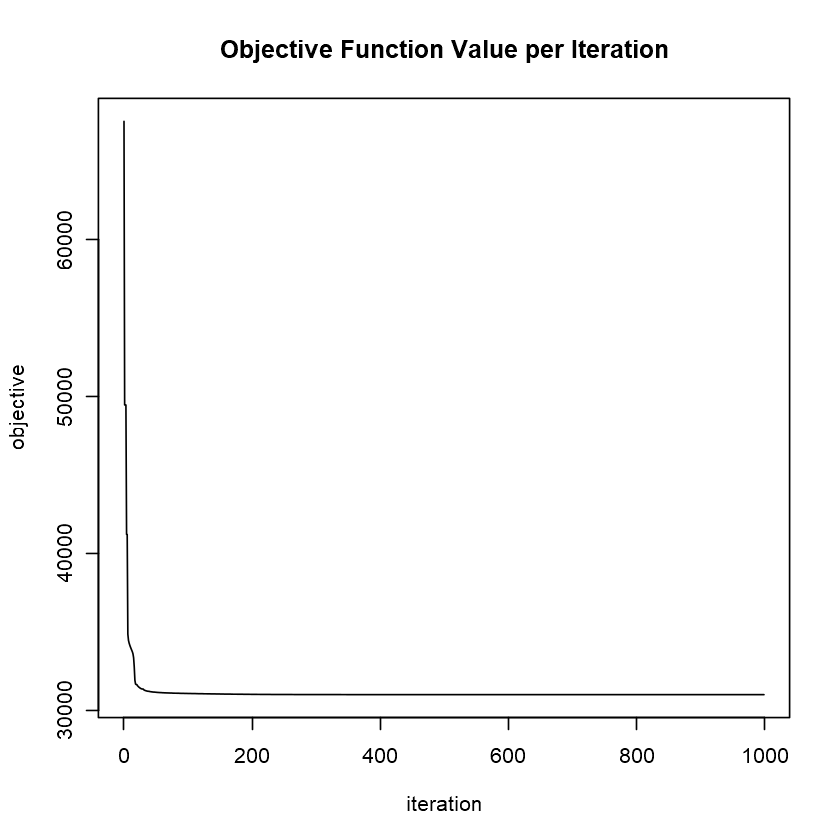

In [14]:
plot(basic_glrm)

In [16]:
basic_glrm@model$importance

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Standard deviation,1.51391887,1.47376825,1.45911373,1.44063487,1.43527873,1.41154352,1.2533073,1.0263865,1.01023787,1.00725266,0.98872380,0.98532001,0.97045298,0.96430274,0.95161001,0.94797772,0.94482594,0.93294275,0.93174514,0.92420709
Proportion of Variance,0.05457025,0.05171412,0.05069078,0.04941497,0.04904821,0.04743941,0.0373995,0.0250826,0.02429954,0.02415614,0.02327559,0.02311561,0.02242331,0.02213999,0.02156099,0.02139671,0.02125467,0.02072338,0.02067021,0.02033711
Cumulative Proportion,0.05457025,0.10628436,0.15697514,0.20639012,0.25543833,0.30287774,0.3402772,0.3653598,0.38965938,0.41381552,0.43709111,0.46020672,0.48263003,0.50477002,0.52633101,0.54772772,0.56898239,0.58970577,0.61037599,0.63071310


In [18]:
ve <- data.frame(
    PC  = basic_glrm@model$importance %>% seq_along(),
    PVE = basic_glrm@model$importance %>% .[2,] %>% unlist(),
    CVE = basic_glrm@model$importance %>% .[3,] %>% unlist()
)
ve %>% head

,PC,PVE,CVE
,<int>,<dbl>,<dbl>
pc1,1,0.05457025,0.05457025
pc2,2,0.05171412,0.10628436
pc3,3,0.05069078,0.15697514
pc4,4,0.04941497,0.20639012
pc5,5,0.04904821,0.25543833
pc6,6,0.04743941,0.30287774


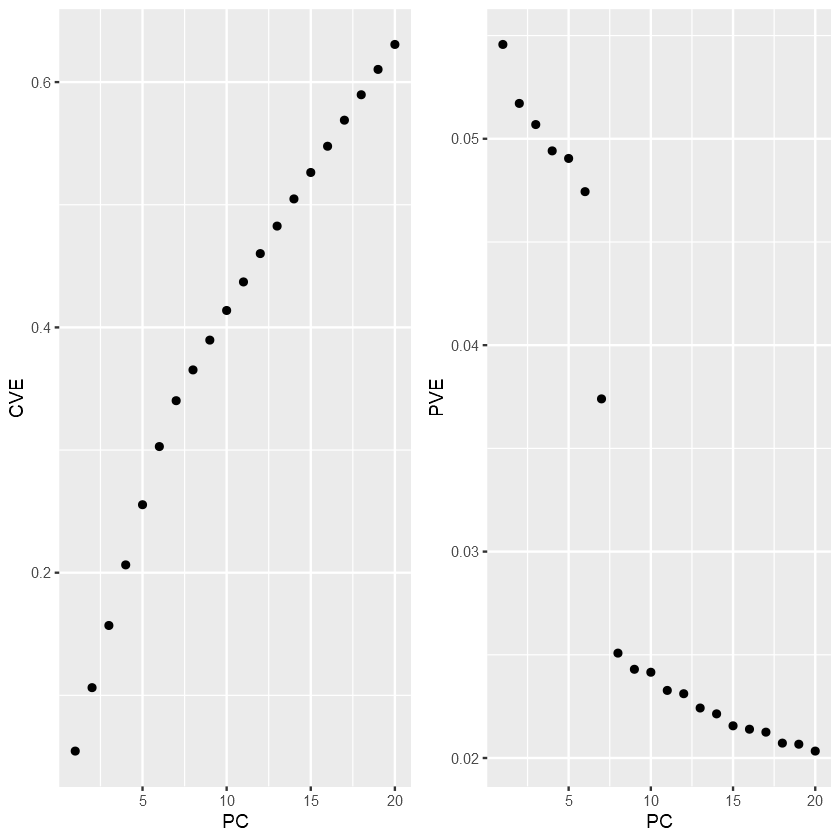

In [21]:
p1 <- ggplot(ve, aes(PC, CVE)) + geom_point()
p2 <- ggplot(ve, aes(PC, PVE)) + geom_point()
gridExtra::grid.arrange(p1, p2, nrow = 1)

### 각 Arch에대한 변수별 영향력

In [24]:
t(basic_glrm@model$archetypes) %>% head

,Arch1,Arch2,Arch3,Arch4,Arch5,Arch6,Arch7,Arch8,Arch9,Arch10,Arch11,Arch12,Arch13,Arch14,Arch15,Arch16,Arch17,Arch18,Arch19,Arch20
7up,-0.57463071,-1.5702621,0.9907660,-0.9335919,0.17678524,0.3490532,1.4509611,0.22944182,-0.2603724,0.56534298,0.2588362,-1.2532674,1.31523600,0.3766145,1.6222527,3.3458560,0.5794821,-0.09590671,-0.06239634,0.3926856
lasagna,0.21901025,0.1213471,-0.7069038,0.8441723,3.56183778,-0.9601863,0.2637698,0.08335172,-0.4267591,-0.19529287,-0.9520205,1.0143890,-0.43890816,0.2733041,-0.2446949,0.2383382,0.3919773,2.92312728,0.20319387,0.7217228
pepsi,-0.24897154,-0.8155085,-0.7669151,-1.2563080,-0.47583355,0.6209472,3.4646346,0.79150394,-0.5544192,0.02318496,0.4415946,-0.9589086,-0.07071473,0.1478579,0.8105671,1.8191354,0.7688919,-1.04537840,-0.31201227,0.5426494
yop,-0.18871778,0.3997875,-0.4856819,1.1622885,-0.26246037,-1.6578109,5.2989491,-0.82291372,0.8842261,0.44352700,0.7112739,0.0849247,-0.90782340,-0.1064536,0.2906010,-0.9557427,-0.1821650,-1.15081385,-1.67568774,1.0490059
redwine,-0.13603233,-0.1058262,-0.9579185,0.4632044,-0.08498506,0.0925273,0.5359363,2.73662608,0.4843709,0.98043885,-0.6401542,3.1828435,-0.27318343,0.3661761,1.2722608,-0.2521197,-0.7531580,-0.44729627,-1.19175937,-0.1337714
cheese,0.01426308,-0.6411114,-0.7574530,-0.1895783,0.46579762,1.5573037,-0.6570389,-0.32236044,-0.4334573,2.95961680,2.9706845,-0.1226705,-0.28507666,0.7370642,1.9268408,-0.8302708,-0.3491758,-0.42336476,-0.52780551,1.3105851


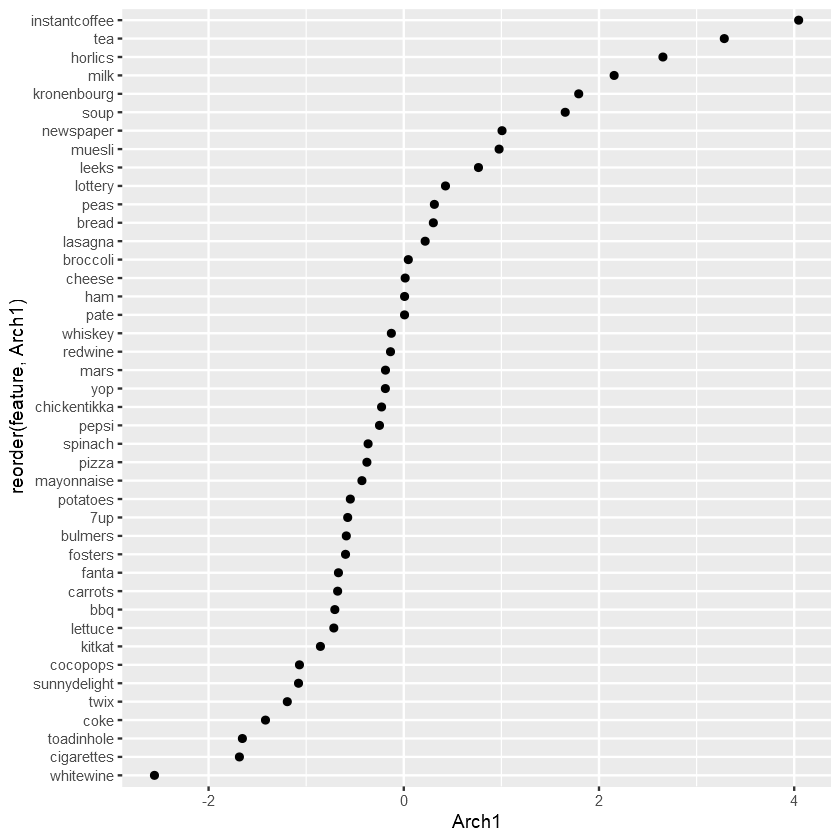

In [30]:
p1 <- t(basic_glrm@model$archetypes) %>% 
  as.data.frame() %>% 
  mutate(feature = row.names(.)) %>%
  ggplot(aes(Arch1, reorder(feature, Arch1))) +
  geom_point()
p1

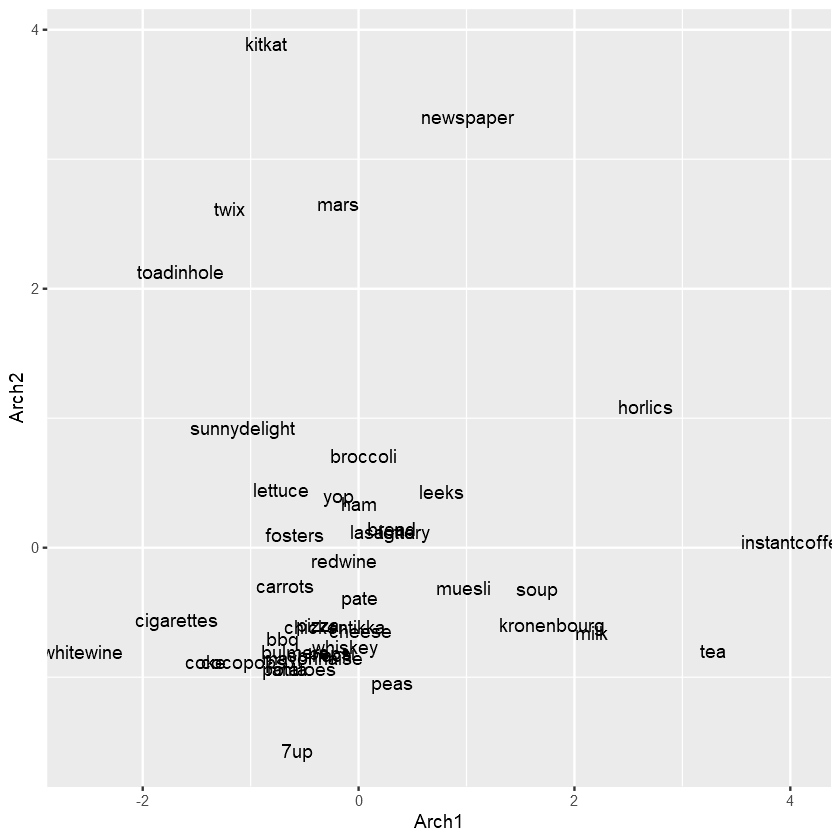

In [28]:
p2 <- t(basic_glrm@model$archetypes) %>% 
  as.data.frame() %>% 
  mutate(feature = row.names(.)) %>%
  ggplot(aes(Arch1, Arch2, label = feature)) +
  geom_text()
p2

### ```h2o.reconstruct()```
- 데이터 세트에 적용하여 예측

#### k = 8을 적용

In [38]:
k8_glrm <- h2o.glrm(
  training_frame = my_basket.h2o,
  k = 8, 
  loss = "Quadratic",
  regularization_x = "None", 
  regularization_y = "None", 
  transform = "STANDARDIZE", 
  max_iterations = 2000,
  seed = 123
)

In [39]:
my_reconstruction <- h2o.reconstruct(k8_glrm, my_basket.h2o, reverse_transform = TRUE)

- my_basket 데이터가 구매한 각 제품의 수라는 점을 고려할 때, 값을 반올림

In [43]:
my_reconstruction %>% round %>% head

,reconstr_7up,reconstr_lasagna,reconstr_pepsi,reconstr_yop,reconstr_red.wine,reconstr_cheese,reconstr_bbq,reconstr_bulmers,reconstr_mayonnaise,reconstr_horlics,...,reconstr_instant.coffee,reconstr_twix,reconstr_potatoes,reconstr_fosters,reconstr_soup,reconstr_toad.in.hole,reconstr_coco.pops,reconstr_kitkat,reconstr_broccoli,reconstr_cigarettes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,1
5,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 미래의 데이터에 대한 최적화 튜닝
- GLRM을 사용하여 향후 관찰에 점수를 매길 때 최종 모델을 결정하는 데 선호되는 접근 방식은 검증 프로세스를 수행하여 최적으로 조정된 모델을 선택하는 것
- **최종 모델이 미래의 데이터에 적용할 때 정규화를 사용하면 과적합을 줄이고 모델을 더 잘 일반화하는 데 도움**

정규화 모델 생성

In [45]:
k8_glrm_regularized <- h2o.glrm(
  training_frame = my_basket.h2o,
  k = 8, 
  loss = "Quadratic",
  regularization_x = "NonNegative", 
  regularization_y = "NonNegative",
  gamma_x = 0.5,
  gamma_y = 0.5,
  transform = "STANDARDIZE", 
  max_iterations = 2000,
  seed = 123
)

In [46]:
predict(k8_glrm_regularized, my_basket.h2o) %>% head

,reconstr_7up,reconstr_lasagna,reconstr_pepsi,reconstr_yop,reconstr_red.wine,reconstr_cheese,reconstr_bbq,reconstr_bulmers,reconstr_mayonnaise,reconstr_horlics,...,reconstr_instant.coffee,reconstr_twix,reconstr_potatoes,reconstr_fosters,reconstr_soup,reconstr_toad.in.hole,reconstr_coco.pops,reconstr_kitkat,reconstr_broccoli,reconstr_cigarettes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0000000,0,0.0000000,0.0000000,0.0000000,0.7305819,0,0.0000000,0.7039545,0.0000000,...,0.0000000,1.183933,0.000000,0.0000000,0,0,0.0000000,0.946048,0.000000,0.8713888
2,0.0000000,0,0.0000000,0.0000000,0.0000000,0.0000000,0,0.0000000,0.0000000,0.4368386,...,0.6582171,0.000000,1.289529,0.0000000,0,0,0.5065563,0.000000,1.441665,0.0000000
3,0.0000000,0,0.0000000,0.0000000,0.0000000,0.0000000,0,0.0000000,0.0000000,1.0311949,...,1.5537779,0.000000,0.000000,0.0000000,0,0,1.1957694,0.000000,0.000000,0.0000000
4,0.6096557,0,0.6311423,0.4565652,0.6697341,0.0000000,0,0.6892642,0.0000000,0.0000000,...,0.0000000,1.378748,0.000000,0.6714834,0,0,0.0000000,1.101719,0.000000,1.0147751
5,0.0000000,0,0.0000000,0.0000000,0.8257145,0.0000000,0,0.8497932,0.0000000,0.0000000,...,0.0000000,0.000000,0.000000,0.8278713,0,0,0.0000000,0.000000,0.000000,0.0000000
6,0.7549035,0,0.7815091,0.5653399,0.0000000,0.0000000,0,0.0000000,0.0000000,0.0000000,...,0.0000000,0.000000,0.000000,0.0000000,0,0,0.0000000,0.000000,0.000000,0.0000000


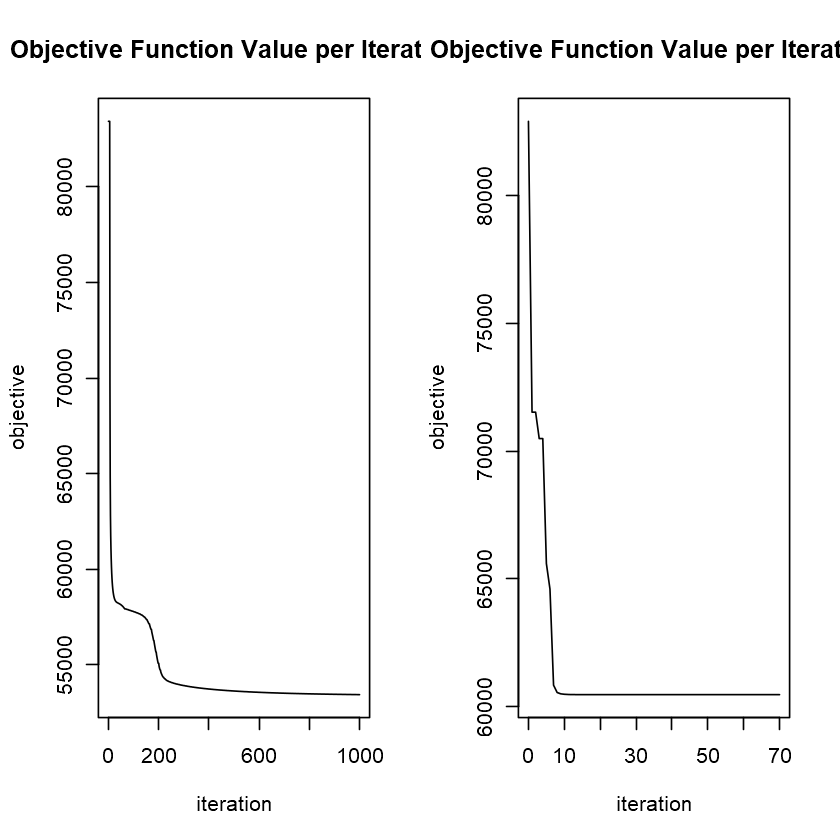

In [48]:
par(mfrow = c(1, 2))
plot(k8_glrm) ; plot(k8_glrm_regularized)

### 그리드서치

In [49]:
split <- h2o.splitFrame(my_basket.h2o, ratios = 0.75, seed = 123)
train <- split[[1]]
valid <- split[[2]]

In [52]:
params <- expand.grid(
  regularization_x = c("None", "NonNegative", "L1"),
  regularization_y = c("None", "NonNegative", "L1"),
  gamma_x = seq(0, 1, by = .25),
  gamma_y = seq(0, 1, by = .25),
  error = 0,
  stringsAsFactors = FALSE
  )
head(params) ; dim(params)

,regularization_x,regularization_y,gamma_x,gamma_y,error
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,None,None,0,0,0
2,NonNegative,None,0,0,0
3,L1,None,0,0,0
4,None,NonNegative,0,0,0
5,NonNegative,NonNegative,0,0,0
6,L1,NonNegative,0,0,0


[1] 225   5

In [53]:
for(i in seq_len(nrow(params))) {
  
  glrm_model <- h2o.glrm(
    training_frame = train,
    k = 8, 
    loss = "Quadratic",
    regularization_x = params$regularization_x[i], 
    regularization_y = params$regularization_y[i],
    gamma_x = params$gamma_x[i],
    gamma_y = params$gamma_y[i],
    transform = "STANDARDIZE", 
    max_runtime_secs = 1000,
    seed = 123
  )
  
  validate <- h2o.performance(glrm_model, valid)
  params$error[i] <- validate@metrics$numerr
}

In [55]:
params %>% arrange(error) %>% head

,regularization_x,regularization_y,gamma_x,gamma_y,error
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,None,None,0.00,0,13779.36
2,L1,None,0.00,0,13779.36
3,None,L1,0.00,0,13779.36
4,L1,L1,0.00,0,13779.36
5,None,None,0.25,0,13779.36
6,None,L1,0.25,0,13779.36


#### 최적의 초매개변수를 적용

In [56]:
final_glrm_model <- h2o.glrm(
  training_frame = my_basket.h2o,
  k = 8, 
  loss = "Quadratic",
  regularization_x = "L1", 
  regularization_y = "NonNegative",
  gamma_x = 1,
  gamma_y = 0.25,
  transform = "STANDARDIZE", 
  max_iterations = 2000,
  seed = 123
)

In [57]:
new_observations <- as.h2o(sample_n(my_basket, 2))

In [58]:
predict(final_glrm_model, new_observations) %>% round

  reconstr_7up reconstr_lasagna reconstr_pepsi reconstr_yop reconstr_red.wine
1            0                0              0            0                 0
2            0                0              0            0                 0
  reconstr_cheese reconstr_bbq reconstr_bulmers reconstr_mayonnaise
1               0            0                0                   0
2               0            0                0                   0
  reconstr_horlics reconstr_chicken.tikka reconstr_milk reconstr_mars
1                0                      0             0             0
2                0                      0             0             0
  reconstr_coke reconstr_lottery reconstr_bread reconstr_pizza
1             0                0              0              0
2             0                0              0              0
  reconstr_sunny.delight reconstr_ham reconstr_lettuce reconstr_kronenbourg
1                      0            0                0                    0
2          

In [59]:
h2o.shutdown(prompt = FALSE)